In [1]:
import pandas as pd

data = pd.read_csv('data.csv', sep=';', encoding='latin1')

In [2]:
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
nltk.download('rslp')

stop_words = set(stopwords.words('portuguese'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Zá-úÁ-ÚçÇ\s]', '', text)
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

data['text'] = data['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rodrigopierre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     /home/rodrigopierre/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [3]:
from sklearn.model_selection import train_test_split

X = data['text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)


2025-01-26 13:17:27.421558: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-26 13:17:27.824182: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-26 13:17:28.153166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737908248.407372    6338 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737908248.475949    6338 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 13:17:29.220813: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [5]:
# Salvar o vocabulário do conjunto de treinamento
with open('vocabulary.txt', 'w') as f:
    for word, index in tokenizer.word_index.items():
        f.write(f"{word}:{index}\n")


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/home/rodrigopierre/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-01-26 13:17:54.748067: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step - accuracy: 0.5552 - loss: 0.6897 - val_accuracy: 0.4848 - val_loss: 0.6771
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.7071 - loss: 0.6412 - val_accuracy: 0.8424 - val_loss: 0.5707
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8496 - loss: 0.4758 - val_accuracy: 0.9152 - val_loss: 0.3409
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.9491 - loss: 0.2261 - val_accuracy: 0.8848 - val_loss: 0.3170
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.9730 - loss: 0.1215 - val_accuracy: 0.9091 - val_loss: 0.2437
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9839 - loss: 0.0561 - val_accuracy: 0.8667 - val_loss: 0.3412
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9940 - loss: 0.0380 - val_accuracy: 0.9030 - val_loss: 0.2443
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9988 - loss: 0.0207 - val_accuracy: 0

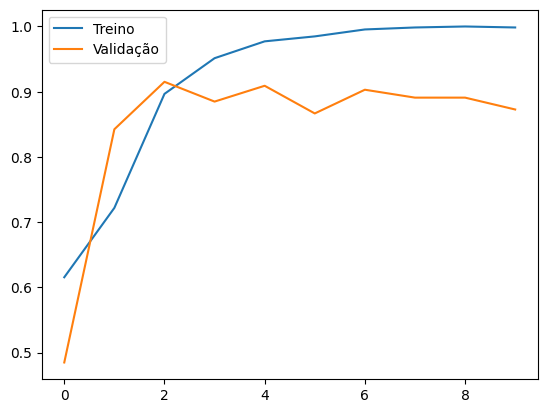

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.legend()
plt.show()


In [9]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Acurácia no conjunto de teste: {accuracy * 100:.2f}%')


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8456 - loss: 0.4233
Acurácia no conjunto de teste: 87.27%


In [11]:
# Exemplos para teste

new_comments = ["O serviço é muito bom e o pessoal é muito atencioso.", "Achei muito top o celular!"]
new_comments_seq = tokenizer.texts_to_sequences(new_comments)
new_comments_pad = pad_sequences(new_comments_seq, maxlen=100)

predictions = model.predict(new_comments_pad)
print(['Positivo' if p > 0.5 else 'Negativo' for p in predictions])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
['Positivo', 'Positivo']
